In [1]:
import numpy as np
import sklearn
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
categorical_df = pd.read_excel(r"/Users/lyfan/Desktop/widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quantitative_df = pd.read_excel(r"/Users/lyfan/Desktop/widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
functional_df = pd.read_csv(r"/Users/lyfan/Desktop/widsdatathon2025/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
target_df=pd.read_excel(r"/Users/lyfan/Desktop/widsdatathon2025/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")
df_0=pd.merge(target_df,categorical_df,on='participant_id')
df_1 = pd.merge(df_0, quantitative_df, on='participant_id')
df= pd.merge(df_1, functional_df, on='participant_id')

Sex_F           0    1
ADHD_Outcome          
0             216  166
1             581  250


<Figure size 800x600 with 0 Axes>

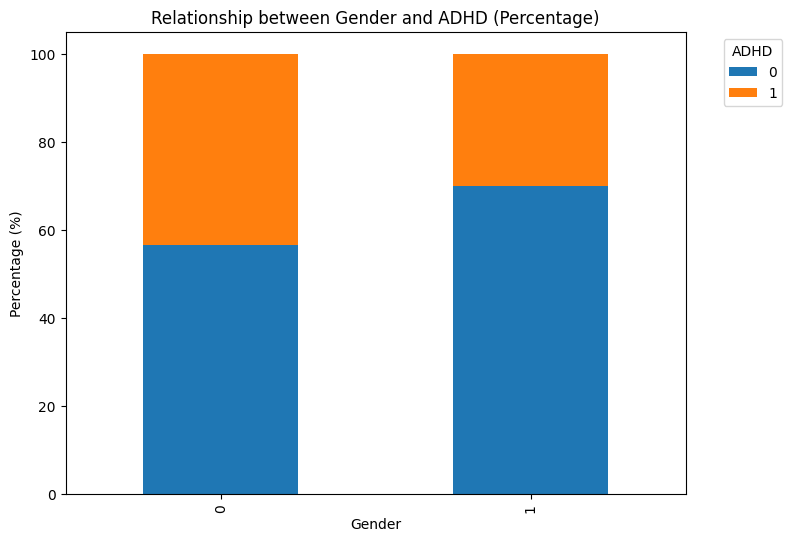

In [2]:
##gender/ADHD
contingency_table = pd.crosstab(target_df['ADHD_Outcome'], target_df['Sex_F'])
print(contingency_table)
percent_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
plt.figure(figsize=(8, 6))
ax = percent_table.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Relationship between Gender and ADHD (Percentage)")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.legend(title="ADHD", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# ##Missing Value Treatment
# from scipy.stats import chi2_contingency
# df_0=pd.merge(target_df,categorical_df,on='participant_id')
# df_1 = pd.merge(df_0, quantitative_df, on='participant_id')
# df= pd.merge(df_1, functional_df, on='participant_id')
# missing_by_gender=df.groupby('ADHD_Outcome').apply(lambda group:group.isnull().mean())
# for col in df.columns:
#     if col == 'ADHD_Outcome':
#         continue  
#     n_missing = df[col].isnull().sum()
#     if n_missing > 0:
#         print("=" * 50)
#         print(f"name： {col}\t missing_count： {n_missing}")
#         if pd.api.types.is_numeric_dtype(df[col]):
#             print("muneric_type")
#         else:
#             print("other")
#         missing_indicator = df[col].isnull()
#         contingency = pd.crosstab(df['ADHD_Outcome'], missing_indicator)
#         print("column_contingency:")
#         print(contingency)
#         if contingency.shape[0] >= 2 and contingency.shape[1] >= 2:
#             chi2, p_value, dof, expected = chi2_contingency(contingency)
#             print(f"chi2_test：Chi2 = {chi2:.4f}, free= {dof}, p-value = {p_value:.4f}")
#         else:
#             print("error")
# ##
# # # PreInt_Demos_Fam_Child_Ethnicity 0.03374777975133215
# # # PreInt_Demos_Fam_Child_Race 0.04262877442273535
# # # Barratt_Barratt_P2_Edu 0.15097690941385436
# # # Barratt_Barratt_P2_Occ 0.16341030195381884
# # # MRI_Track_Age_at_Scan 0.30106571936056836

name： PreInt_Demos_Fam_Child_Ethnicity	 missing_count： 43
muneric_type
column_contingency:
PreInt_Demos_Fam_Child_Ethnicity  False  True 
ADHD_Outcome                                  
0                                   357     25
1                                   813     18
chi2_test：Chi2 = 13.4201, free= 1, p-value = 0.0002
name： PreInt_Demos_Fam_Child_Race	 missing_count： 54
muneric_type
column_contingency:
PreInt_Demos_Fam_Child_Race  False  True 
ADHD_Outcome                             
0                              352     30
1                              807     24
chi2_test：Chi2 = 14.0236, free= 1, p-value = 0.0002
name： MRI_Track_Scan_Location	 missing_count： 3
muneric_type
column_contingency:
MRI_Track_Scan_Location  False  True 
ADHD_Outcome                         
0                          381      1
1                          829      2
chi2_test：Chi2 = 0.3064, free= 1, p-value = 0.5799
name： Barratt_Barratt_P1_Edu	 missing_count： 15
muneric_type
column_contingency

In [3]:
exclude_cols = ["PreInt_Demos_Fam_Child_Race", "PreInt_Demos_Fam_Child_Ethnicity"]
cols_to_clean = [
    col for col in df.columns 
    if (col not in exclude_cols) and (0 < df[col].isnull().mean() < 0.05)
]
for col in cols_to_clean:
    before_rows = df_1.shape[0]
    df_1 = df_1.dropna(subset=[col])
print(df_1.isna().sum().sum())        

779


In [8]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

df_tmp = df_1.drop(columns=["participant_id"]).reset_index(drop=True)
id_tmp = df_1["participant_id"].reset_index(drop=True)

categorical_cols = [
    'PreInt_Demos_Fam_Child_Ethnicity',
    'PreInt_Demos_Fam_Child_Race',
    'Barratt_Barratt_P2_Edu',
    'Barratt_Barratt_P2_Occ'
]
numeric_cols = ['MRI_Track_Age_at_Scan']
other_cols = df_tmp.drop(columns=numeric_cols + categorical_cols)
print("Step 2: Imputing continuous variables...")
if numeric_cols:
    df_numeric = df_tmp[numeric_cols].copy()
    imp_continuous = IterativeImputer(
        estimator=ExtraTreesRegressor(
            n_estimators=100,
            max_depth=None,
            min_samples_leaf=2,
            random_state=0,
            n_jobs=-1
        ),
        tol=1e-4,
        max_iter=30,
        random_state=0,
        verbose=2
    )
    df_imputed_numeric_all = pd.DataFrame(
        imp_continuous.fit_transform(df_numeric),
        columns=numeric_cols,
        index=df_numeric.index
    )
    for col in numeric_cols:
        na_mask = df_numeric[col].isna()
        df_numeric.loc[na_mask, col] = df_imputed_numeric_all.loc[na_mask, col]
else:
    df_numeric = pd.DataFrame()

df_numeric = df_numeric.reset_index(drop=True)

print("Step 3: Imputing categorical variables...")
if categorical_cols:
    df_cat_enc = pd.DataFrame(index=df_tmp.index)
    encoders = {}
    for col in categorical_cols:
        notna = df_tmp[col].notna()
        le = LabelEncoder().fit(df_tmp.loc[notna, col].astype(str))
        encoders[col] = le
        df_cat_enc[col] = np.nan
        df_cat_enc.loc[notna, col] = le.transform(df_tmp.loc[notna, col].astype(str))

    imp_cat = IterativeImputer(
        estimator=GradientBoostingClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=0
        ),
        tol=1e-4,
        max_iter=30,
        random_state=0,
        verbose=2
    )
    df_cat_imp_all = pd.DataFrame(
        imp_cat.fit_transform(df_cat_enc),
        columns=categorical_cols,
        index=df_cat_enc.index
    )

    df_cat_filled = df_cat_enc.copy()
    for col in categorical_cols:
        na_mask = df_tmp[col].isna()
        df_cat_filled.loc[na_mask, col] = df_cat_imp_all.loc[na_mask, col]
        # clip & inverse_transform
        codes = df_cat_filled[col].round(0).clip(
            df_cat_enc[col].min(),
            df_cat_enc[col].max()
        ).astype(int)
        df_cat_filled[col] = encoders[col].inverse_transform(codes)
    df_imputed_categorical = df_cat_filled.reset_index(drop=True)
else:
    df_imputed_categorical = pd.DataFrame()
print("Step 4: Merging imputed data...")
df_filled = pd.concat([df_numeric, df_imputed_categorical, other_cols.reset_index(drop=True)], axis=1)
df_filled.insert(0, "participant_id", id_tmp)

missing_count = df_filled.isna().sum().sum()
print(f"Missing counts after imputation: {missing_count}")


Step 2: Imputing continuous variables...
Step 3: Imputing categorical variables...
[IterativeImputer] Completing matrix with shape (1126, 4)
[IterativeImputer] Ending imputation round 1/30, elapsed time 1.38
[IterativeImputer] Change: 9.392994518917286, scaled tolerance: 0.0009000000000000001 
[IterativeImputer] Ending imputation round 2/30, elapsed time 2.75
[IterativeImputer] Change: 5.0, scaled tolerance: 0.0009000000000000001 
[IterativeImputer] Ending imputation round 3/30, elapsed time 4.10
[IterativeImputer] Change: 5.0, scaled tolerance: 0.0009000000000000001 
[IterativeImputer] Ending imputation round 4/30, elapsed time 5.45
[IterativeImputer] Change: 0.0, scaled tolerance: 0.0009000000000000001 
[IterativeImputer] Early stopping criterion reached.
Step 4: Merging imputed data...
Missing counts after imputation: 0


In [10]:
print(df_filled.head())

  participant_id  MRI_Track_Age_at_Scan PreInt_Demos_Fam_Child_Ethnicity  \
0   UmrK0vMLopoR              11.249990                              0.0   
1   CPaeQkhcjg7d              11.249990                              1.0   
2   Nb4EetVPm3gs               8.239904                              1.0   
3   p4vPhVu91o4b              11.249990                              0.0   
4   M09PXs7arQ5E               8.940679                              0.0   

  PreInt_Demos_Fam_Child_Race Barratt_Barratt_P2_Edu Barratt_Barratt_P2_Occ  \
0                         0.0                   21.0                   45.0   
1                         2.0                   12.0                   15.0   
2                         8.0                    9.0                    0.0   
3                         8.0                   18.0                    0.0   
4                         1.0                   18.0                   35.0   

   ADHD_Outcome  Sex_F  Basic_Demos_Enroll_Year  Basic_Demos_Study_S

In [11]:
###FMRI_METRIC
import numpy as np
import pandas as pd
df_aa=pd.merge(df_filled, functional_df, on='participant_id',how='inner')
df_model=pd.merge(df_aa, target_df, on='participant_id',how='inner')
functional_cols = [col for col in functional_df.columns if col != 'participant_id']
conn_df = df_model[functional_cols]
N,M = conn_df.shape
from math import sqrt
P = int((1 + sqrt(1 + 8 * M)) / 2)
tri_u = np.triu_indices(P, k=1)
brain_matrices = np.zeros((N, P, P))
for i in range(N):
    matrix = np.zeros((P, P))
    values = conn_df.iloc[i].values
    matrix[tri_u] = values
    matrix = matrix + matrix.T  
    brain_matrices[i] = matrix

In [16]:
print(df_model.head())

  participant_id  MRI_Track_Age_at_Scan PreInt_Demos_Fam_Child_Ethnicity  \
0   UmrK0vMLopoR              11.249990                              0.0   
1   CPaeQkhcjg7d              11.249990                              1.0   
2   Nb4EetVPm3gs               8.239904                              1.0   
3   p4vPhVu91o4b              11.249990                              0.0   
4   M09PXs7arQ5E               8.940679                              0.0   

  PreInt_Demos_Fam_Child_Race Barratt_Barratt_P2_Edu Barratt_Barratt_P2_Occ  \
0                         0.0                   21.0                   45.0   
1                         2.0                   12.0                   15.0   
2                         8.0                    9.0                    0.0   
3                         8.0                   18.0                    0.0   
4                         1.0                   18.0                   35.0   

   ADHD_Outcome_x  Sex_F_x  Basic_Demos_Enroll_Year  Basic_Demos_Stu

In [ ]:
import os
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

# === 0. Load original data ===
# Copy model DataFrame
df_model2 = df_model.copy()
# fMRI connectivity matrices, shape (N, P, P)
X1_np = brain_matrices.astype(np.float32)
# Behavioral and demographic features, shape (N, K)
X2_np = df_model2.drop(columns=["participant_id", "ADHD_Outcome_x", "Sex_F_x"]).values.astype(np.float32)
# Labels for ADHD outcome and Sex, shape (N, 2)
Y_np  = df_model[["ADHD_Outcome_x", "Sex_F_x"]].values.astype(np.float32)

# Convert to torch.Tensors
X1 = torch.tensor(X1_np, dtype=torch.float32)
X2 = torch.tensor(X2_np, dtype=torch.float32)
Y  = torch.tensor(Y_np, dtype=torch.float32)


X1_tr, X1_val, X2_tr, X2_val, Y_tr, Y_val = train_test_split(
    X1, X2, Y, test_size=0.2, random_state=42
)

train_ds      = TensorDataset(X1_tr, X2_tr, Y_tr)
base_train_ds = train_ds  
val_ds        = TensorDataset(X1_val, X2_val, Y_val)

In [ ]:
# 必要的导入
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载原始数据
X1_np = brain_matrices.astype(np.float32)  # fMRI
X2_np = df_model.drop(columns=["participant_id"]).values.astype(np.float32)  # 行为特征
Y_np = df_model[["ADHD_Outcome_y", "Sex_F_y"]].values.astype(np.float32)  # 标签

# PCA 降维
pca = PCA(n_components=0.95, random_state=42)
X2_np_reduced = pca.fit_transform(X2_np)
print(f"PCA reduced behavior features from {X2_np.shape[1]} to {X2_np_reduced.shape[1]} dimensions.")

# 转为 PyTorch Tensor
X1 = torch.tensor(X1_np, dtype=torch.float32)
X2 = torch.tensor(X2_np_reduced, dtype=torch.float32)
Y  = torch.tensor(Y_np, dtype=torch.float32)

# 训练验证划分
X1_tr, X1_val, X2_tr, X2_val, Y_tr, Y_val = train_test_split(
    X1, X2, Y, test_size=0.2, random_state=42, stratify=Y[:, 1].numpy()
)

# Fisher-Z 变换 + fMRI 标准化
def normalize_fmri(train, val):
    tr_z = 0.5 * torch.log((1 + train) / (1 - train))
    val_z = 0.5 * torch.log((1 + val) / (1 - val))
    mu = tr_z.mean(dim=0, keepdim=True)
    std = tr_z.std(dim=0, keepdim=True)
    return (tr_z - mu) / (std + 1e-6), (val_z - mu) / (std + 1e-6)

X1_tr, X1_val = normalize_fmri(X1_tr, X1_val)

# 行为特征标准化
mean = X2_tr.mean(dim=0, keepdim=True)
std  = X2_tr.std(dim=0, keepdim=True)
X2_tr = (X2_tr - mean) / (std + 1e-6)
X2_val = (X2_val - mean) / (std + 1e-6)

# 转为 NumPy 格式
X1_tr_all = X1_tr.numpy()
X2_tr_all = X2_tr.numpy()
Y_tr_all  = Y_tr.numpy()
P = X1_tr_all.shape[1]
K = X2_tr_all.shape[1]

# 定义模型
class BrainNetCNN(nn.Module):
    def __init__(self, P, K, e2e, e2n, n2g, fc1, fc2, dropout_p):
        super().__init__()
        self.e2e = nn.Sequential(nn.Conv2d(1, e2e, (1, P)), nn.BatchNorm2d(e2e), nn.ReLU())
        self.e2n = nn.Sequential(nn.Conv2d(e2e, e2n, (P, 1)), nn.BatchNorm2d(e2n), nn.ReLU())
        self.n2g = nn.Sequential(nn.Conv2d(e2n, n2g, (1, 1)), nn.BatchNorm2d(n2g), nn.ReLU())
        self.fc1 = nn.Linear(K, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.classifier = nn.Sequential(
            nn.Linear(n2g + fc2, 64), nn.ReLU(), nn.Dropout(dropout_p), nn.Linear(64, 1)
        )

    def forward(self, conn, behav):
        x = conn.unsqueeze(1)
        x = self.e2e(x)
        x = self.e2n(x)
        x = self.n2g(x)
        x = x.view(x.size(0), -1)
        b = F.relu(self.fc1(behav))
        b = self.fc2(b)
        return self.classifier(torch.cat([x, b], dim=1)).squeeze(1)

# 单折训练函数
def run_fold(cfg, train_idx, val_idx, X1_all, X2_all, Y_all, P, K):
    X1_tr, X2_tr, y_tr = X1_all[train_idx], X2_all[train_idx], Y_all[train_idx, 1].astype(int)
    X1_val, X2_val, y_val = X1_all[val_idx], X2_all[val_idx], Y_all[val_idx, 1].astype(int)

    flat = X1_tr.reshape(X1_tr.shape[0], -1)
    X_comb, y_res = SMOTE().fit_resample(np.hstack([flat, X2_tr]), y_tr)

    X1_res = torch.tensor(X_comb[:, :P*P].reshape(-1, P, P), dtype=torch.float32)
    X2_res = torch.tensor(X_comb[:, P*P:], dtype=torch.float32)
    y_res = torch.tensor(y_res, dtype=torch.float32)

    # 权重采样器
    pos, neg = int(y_res.sum()), len(y_res) - int(y_res.sum())
    weights = torch.ones(len(y_res))
    weights[y_res == 1] = neg / pos
    sampler = WeightedRandomSampler(weights.numpy(), len(weights))

    # 数据加载器
    tr_loader = DataLoader(TensorDataset(X1_res, X2_res, y_res.unsqueeze(1)),
                           batch_size=cfg['batch_size'], sampler=sampler)
    val_loader = DataLoader(TensorDataset(
        torch.tensor(X1_val, dtype=torch.float32),
        torch.tensor(X2_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    ), batch_size=cfg['batch_size'], shuffle=False)

    model = BrainNetCNN(P, K, cfg['e2e_channels'], cfg['e2n_channels'], cfg['n2g_channels'],
                        cfg['fc1_channels'], cfg['fc2_channels'], cfg['dropout_p'])

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg['max_lr'],
                                                    steps_per_epoch=len(tr_loader),
                                                    epochs=cfg['epochs'])
    pos_weight = torch.tensor([neg / max(pos, 1)])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Early Stopping
    best_f1 = 0.0
    best_model = None
    patience, counter = 5, 0

    for _ in range(cfg['epochs']):
        model.train()
        for c, b, y in tr_loader:
            optimizer.zero_grad()
            logits = model(c, b)
            loss = criterion(logits, y.squeeze(1))
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for c, b, y in val_loader:
                logits = model(c, b)
                preds = (torch.sigmoid(logits) > 0.5).int().numpy()
                all_preds.append(preds)
                all_labels.append(y.numpy().astype(int))

        f1 = f1_score(np.concatenate(all_labels), np.concatenate(all_preds))
        if f1 > best_f1:
            best_f1 = f1
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    if best_model: model.load_state_dict(best_model)
    return best_f1

# 超参数搜索
param_grid = {
    'e2e_channels': [16],
    'e2n_channels': [32,64],
    'n2g_channels': [64,128],
    'fc1_channels': [32,64],
    'fc2_channels': [64,128],
    'dropout_p': [0.5],
    'lr': [1e-4],
    'max_lr': [1e-3],
    'weight_decay': [1e-3],
    'batch_size': [16],
    'epochs': [20]
}
grid = list(ParameterGrid(param_grid))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = 0.0
best_cfg = None
for cfg in grid:
    scores = []
    for train_idx, val_idx in skf.split(X2_tr_all, Y_tr_all[:, 1]):
        score = run_fold(cfg, train_idx, val_idx, X1_tr_all, X2_tr_all, Y_tr_all, P, K)
        scores.append(score)
    mean_score = np.mean(scores)
    print(f"cfg={cfg} -> mean F1: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_cfg = cfg

print(f"\nBest cfg: {best_cfg}, F1={best_score:.4f}")

PCA reduced behavior features from 19931 to 333 dimensions.


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7742


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7791


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7538


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7543


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7810


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7870


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7620


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7722


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7619


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7635


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7892


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7747


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7817


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7742


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.7776


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.7514

Best cfg: {'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001}, F1=0.7892



Retraining best model on full training set...


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Evaluating best model on validation set...

 Classification Report for sex prediction:
              precision    recall  f1-score   support

           0     0.8797    0.9392    0.9085       148
           1     0.8676    0.7564    0.8082        78

    accuracy                         0.8761       226
   macro avg     0.8737    0.8478    0.8584       226
weighted avg     0.8756    0.8761    0.8739       226



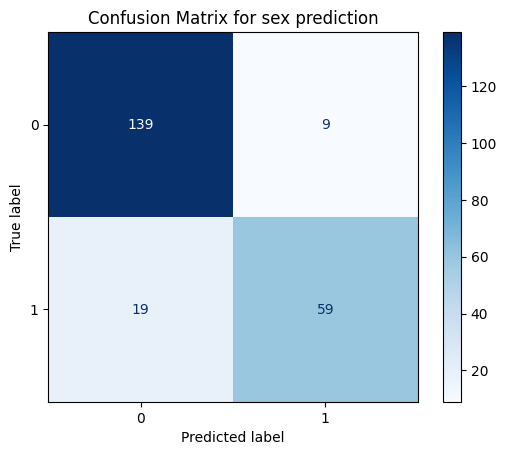

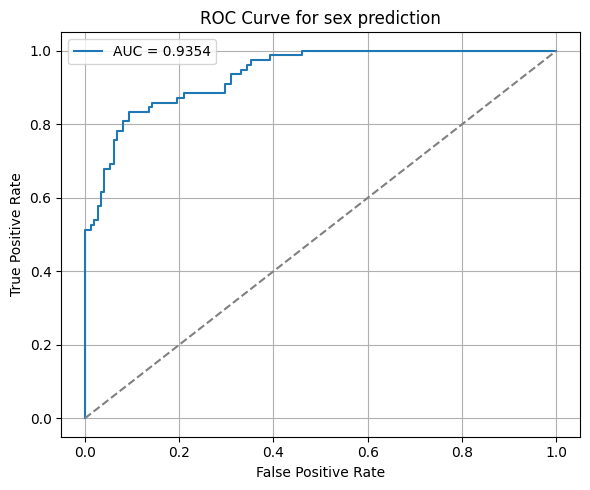

In [46]:
# === 10. Retrain final model using best config ===
print("\nRetraining best model on full training set...")

# 重新使用 SMOTE 重采样全训练集
flat = X1_tr_all.reshape(len(X1_tr_all), -1)
X_comb, y_res = SMOTE(random_state=42).fit_resample(
    np.hstack([flat, X2_tr_all]), Y_tr_all[:, 1].astype(int)
)

X1_res = torch.tensor(X_comb[:, :P*P].reshape(-1, P, P), dtype=torch.float32)
X2_res = torch.tensor(X_comb[:, P*P:], dtype=torch.float32)
y_res = torch.tensor(y_res, dtype=torch.float32)

# 构建 DataLoader
train_loader = DataLoader(
    TensorDataset(X1_res, X2_res, y_res.unsqueeze(1)),
    batch_size=best_cfg['batch_size'], shuffle=True
)

# 初始化模型
final_model = BrainNetCNN(
    P, K,
    best_cfg['e2e_channels'],
    best_cfg['e2n_channels'],
    best_cfg['n2g_channels'],
    best_cfg['fc1_channels'],
    best_cfg['fc2_channels'],
    best_cfg['dropout_p']
)
optimizer = torch.optim.AdamW(final_model.parameters(),
                              lr=best_cfg['lr'], weight_decay=best_cfg['weight_decay'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=best_cfg['max_lr'],
    steps_per_epoch=len(train_loader),
    epochs=best_cfg['epochs']
)
pos_weight = torch.tensor([(len(y_res) - y_res.sum()) / y_res.sum()])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# 模型训练
for _ in range(best_cfg['epochs']):
    final_model.train()
    for c, b, y in train_loader:
        optimizer.zero_grad()
        logits = final_model(c, b)
        loss = criterion(logits, y.squeeze(1))
        loss.backward()
        optimizer.step()
        scheduler.step()

# === 11. Evaluate on validation set ===
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("\nEvaluating best model on validation set...")

# 构建验证集 DataLoader
eval_loader = DataLoader(
    TensorDataset(X1_val, X2_val),
    batch_size=best_cfg['batch_size'], shuffle=False
)

# 模型预测
final_model.eval()
all_logits = []
with torch.no_grad():
    for c, b in eval_loader:
        logits = final_model(c, b)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_logits.extend(probs)

y_prob = np.array(all_logits)
y_pred = (y_prob > 0.5).astype(int)
y_true = Y_val.cpu().numpy()[:, 1].astype(int)

# === Classification Report ===
print("\n Classification Report for sex prediction:")
print(classification_report(y_true, y_pred, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for sex prediction")
plt.show()

# === ROC Curve & AUC ===
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for sex prediction")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold, ParameterGrid
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X1_np = brain_matrices.astype(np.float32)  # fMRI
X2_np = df_model.drop(columns=["participant_id"]).values.astype(np.float32)  # 行为特征
Y_np = df_model[["ADHD_Outcome_y", "Sex_F_y"]].values.astype(np.float32)  # 标签

pca = PCA(n_components=0.95, random_state=42)
X2_np_reduced = pca.fit_transform(X2_np)
print(f"PCA reduced behavior features from {X2_np.shape[1]} to {X2_np_reduced.shape[1]} dimensions.")

X1 = torch.tensor(X1_np, dtype=torch.float32)
X2 = torch.tensor(X2_np_reduced, dtype=torch.float32)
Y  = torch.tensor(Y_np, dtype=torch.float32)

X1_tr, X1_val, X2_tr, X2_val, Y_tr, Y_val = train_test_split(
    X1, X2, Y, test_size=0.2, random_state=42, stratify=Y[:,0].numpy()
)

# Fisher-Z 变换 + fMRI 标准化
def normalize_fmri(train, val):
    tr_z = 0.5 * torch.log((1 + train) / (1 - train))
    val_z = 0.5 * torch.log((1 + val) / (1 - val))
    mu = tr_z.mean(dim=0, keepdim=True)
    std = tr_z.std(dim=0, keepdim=True)
    return (tr_z - mu) / (std + 1e-6), (val_z - mu) / (std + 1e-6)

X1_tr, X1_val = normalize_fmri(X1_tr, X1_val)

# 行为特征标准化
mean = X2_tr.mean(dim=0, keepdim=True)
std  = X2_tr.std(dim=0, keepdim=True)
X2_tr = (X2_tr - mean) / (std + 1e-6)
X2_val = (X2_val - mean) / (std + 1e-6)

# 转为 NumPy 格式
X1_tr_all = X1_tr.numpy()
X2_tr_all = X2_tr.numpy()
Y_tr_all  = Y_tr.numpy()
P = X1_tr_all.shape[1]
K = X2_tr_all.shape[1]

# 定义模型
class BrainNetCNN(nn.Module):
    def __init__(self, P, K, e2e, e2n, n2g, fc1, fc2, dropout_p):
        super().__init__()
        self.e2e = nn.Sequential(nn.Conv2d(1, e2e, (1, P)), nn.BatchNorm2d(e2e), nn.ReLU())
        self.e2n = nn.Sequential(nn.Conv2d(e2e, e2n, (P, 1)), nn.BatchNorm2d(e2n), nn.ReLU())
        self.n2g = nn.Sequential(nn.Conv2d(e2n, n2g, (1, 1)), nn.BatchNorm2d(n2g), nn.ReLU())
        self.fc1 = nn.Linear(K, fc1)
        self.fc2 = nn.Linear(fc1, fc2)
        self.classifier = nn.Sequential(
            nn.Linear(n2g + fc2, 64), nn.ReLU(), nn.Dropout(dropout_p), nn.Linear(64, 1)
        )

    def forward(self, conn, behav):
        x = conn.unsqueeze(1)
        x = self.e2e(x)
        x = self.e2n(x)
        x = self.n2g(x)
        x = x.view(x.size(0), -1)
        b = F.relu(self.fc1(behav))
        b = self.fc2(b)
        return self.classifier(torch.cat([x, b], dim=1)).squeeze(1)

# 单折训练函数
def run_fold(cfg, train_idx, val_idx, X1_all, X2_all, Y_all, P, K):
    X1_tr, X2_tr, y_tr = X1_all[train_idx], X2_all[train_idx], Y_all[train_idx, 0].astype(int)
    X1_val, X2_val, y_val = X1_all[val_idx], X2_all[val_idx], Y_all[val_idx, 0].astype(int)

    flat = X1_tr.reshape(X1_tr.shape[0], -1)
    X_comb, y_res = SMOTE().fit_resample(np.hstack([flat, X2_tr]), y_tr)

    X1_res = torch.tensor(X_comb[:, :P*P].reshape(-1, P, P), dtype=torch.float32)
    X2_res = torch.tensor(X_comb[:, P*P:], dtype=torch.float32)
    y_res = torch.tensor(y_res, dtype=torch.float32)

    # 权重采样器
    pos, neg = int(y_res.sum()), len(y_res) - int(y_res.sum())
    weights = torch.ones(len(y_res))
    weights[y_res == 1] = neg / pos
    sampler = WeightedRandomSampler(weights.numpy(), len(weights))

    # 数据加载器
    tr_loader = DataLoader(TensorDataset(X1_res, X2_res, y_res.unsqueeze(1)),
                           batch_size=cfg['batch_size'], sampler=sampler)
    val_loader = DataLoader(TensorDataset(
        torch.tensor(X1_val, dtype=torch.float32),
        torch.tensor(X2_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
    ), batch_size=cfg['batch_size'], shuffle=False)

    model = BrainNetCNN(P, K, cfg['e2e_channels'], cfg['e2n_channels'], cfg['n2g_channels'],
                        cfg['fc1_channels'], cfg['fc2_channels'], cfg['dropout_p'])

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=cfg['max_lr'],
                                                    steps_per_epoch=len(tr_loader),
                                                    epochs=cfg['epochs'])
    pos_weight = torch.tensor([neg / max(pos, 1)])
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Early Stopping
    best_f1 = 0.0
    best_model = None
    patience, counter = 5, 0

    for _ in range(cfg['epochs']):
        model.train()
        for c, b, y in tr_loader:
            optimizer.zero_grad()
            logits = model(c, b)
            loss = criterion(logits, y.squeeze(1))
            loss.backward()
            optimizer.step()
            scheduler.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for c, b, y in val_loader:
                logits = model(c, b)
                preds = (torch.sigmoid(logits) > 0.5).int().numpy()
                all_preds.append(preds)
                all_labels.append(y.numpy().astype(int))

        f1 = f1_score(np.concatenate(all_labels), np.concatenate(all_preds))
        if f1 > best_f1:
            best_f1 = f1
            best_model = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break

    if best_model: model.load_state_dict(best_model)
    return best_f1


param_grid = {
    'e2e_channels': [16],
    'e2n_channels': [32,64],
    'n2g_channels': [64,128],
    'fc1_channels': [32,64],
    'fc2_channels': [64,128],
    'dropout_p': [0.5,0.7],
    'lr': [1e-4,1e-3],
    'max_lr': [1e-3],
    'weight_decay': [1e-3],
    'batch_size': [16,32],
    'epochs': [30]
}
grid = list(ParameterGrid(param_grid))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = 0.0
best_cfg = None
for cfg in grid:
    scores = []
    for train_idx, val_idx in skf.split(X2_tr_all, Y_tr_all[:, 0]):
        score = run_fold(cfg, train_idx, val_idx, X1_tr_all, X2_tr_all, Y_tr_all, P, K)
        scores.append(score)
    mean_score = np.mean(scores)
    print(f"cfg={cfg} -> mean F1: {mean_score:.4f}")
    if mean_score > best_score:
        best_score = mean_score
        best_cfg = cfg

print(f"\nBest cfg: {best_cfg}, F1={best_score:.4f}")

PCA reduced behavior features from 19931 to 333 dimensions.


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8856


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8740


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8858


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8722


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8747


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8808


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8887


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8830


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8819


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8836


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8813


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 32, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8693


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8787


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 64, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8770


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001} -> mean F1: 0.8800


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/lyfan/Library/Python/3.9/lib/pyth

cfg={'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 64, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 128, 'weight_decay': 0.001} -> mean F1: 0.8716

Best cfg: {'batch_size': 16, 'dropout_p': 0.5, 'e2e_channels': 16, 'e2n_channels': 32, 'epochs': 30, 'fc1_channels': 64, 'fc2_channels': 128, 'lr': 0.0001, 'max_lr': 0.001, 'n2g_channels': 64, 'weight_decay': 0.001}, F1=0.8887



▶ Retraining best model on full training set (ADHD)…


/Users/lyfan/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Epoch  1 | int-val F1=0.6821 | best F1=0.6821
Epoch  2 | int-val F1=0.7943 | best F1=0.7943
Epoch  3 | int-val F1=0.8030 | best F1=0.8030
Epoch  4 | int-val F1=0.8489 | best F1=0.8489
Epoch  5 | int-val F1=0.9008 | best F1=0.9008
Epoch  6 | int-val F1=0.9048 | best F1=0.9048
Epoch  7 | int-val F1=0.9206 | best F1=0.9206
Epoch  8 | int-val F1=0.8960 | best F1=0.9206
Epoch  9 | int-val F1=0.9062 | best F1=0.9206
Epoch 10 | int-val F1=0.9147 | best F1=0.9206
Epoch 11 | int-val F1=0.9219 | best F1=0.9219
Epoch 12 | int-val F1=0.9194 | best F1=0.9219
Epoch 13 | int-val F1=0.9076 | best F1=0.9219
Epoch 14 | int-val F1=0.9206 | best F1=0.9219
Epoch 15 | int-val F1=0.9106 | best F1=0.9219
Early-stopping triggered at epoch 16

Best internal-val F1=0.9219 at threshold=0.10

Classification Report (ADHD):
              precision    recall  f1-score   support

           0     0.7627    0.6429    0.6977        70
           1     0.8503    0.9103    0.8793       156

    accuracy                   

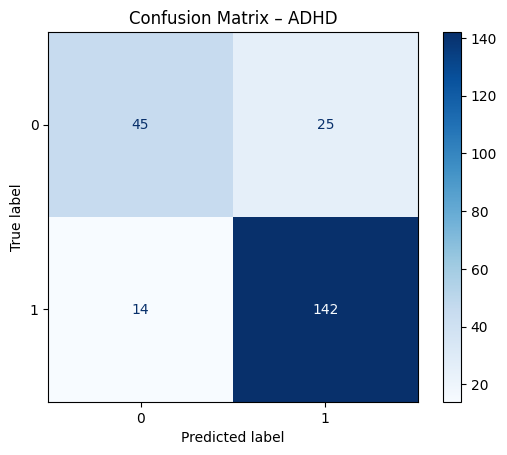

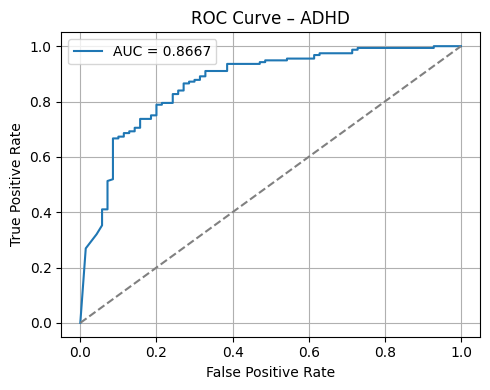

In [55]:
# === 10. Retrain best model on full training set (ADHD) with robust early-stopping ===
print("\n▶ Retraining best model on full training set (ADHD)…")

# ── 10-A. SMOTE on full training data ────────────────────────────────────────────
flat = X1_tr_all.reshape(len(X1_tr_all), -1)
X_comb, y_comb = SMOTE(random_state=42).fit_resample(
    np.hstack([flat, X2_tr_all]), Y_tr_all[:, 0].astype(int)
)

X1_res = torch.tensor(X_comb[:, :P*P].reshape(-1, P, P), dtype=torch.float32)
X2_res = torch.tensor(X_comb[:, P*P:],              dtype=torch.float32)
y_res  = torch.tensor(y_comb, dtype=torch.float32)

# ── 10-B. carve out a 10 % internal-val split for early-stopping ────────────────
val_ratio = 0.10
n_val     = int(len(X1_res) * val_ratio)
perm      = torch.randperm(len(X1_res))
val_idx   = perm[:n_val]
trn_idx   = perm[n_val:]

ds_train = TensorDataset(X1_res[trn_idx], X2_res[trn_idx], y_res[trn_idx].unsqueeze(1))
ds_intvl = TensorDataset(X1_res[val_idx], X2_res[val_idx], y_res[val_idx].unsqueeze(1))

train_loader = DataLoader(ds_train, batch_size=best_cfg['batch_size'], shuffle=True)
intvl_loader = DataLoader(ds_intvl, batch_size=best_cfg['batch_size'], shuffle=False)

# ── 10-C. build & optimise model ────────────────────────────────────────────────
final_model = BrainNetCNN(
    P, K,
    best_cfg['e2e_channels'], best_cfg['e2n_channels'], best_cfg['n2g_channels'],
    best_cfg['fc1_channels'], best_cfg['fc2_channels'], best_cfg['dropout_p']
).to(device)

opt = torch.optim.AdamW(final_model.parameters(),
                        lr=best_cfg['lr'], weight_decay=best_cfg['weight_decay'])
sched = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=best_cfg['max_lr'],
    steps_per_epoch=len(train_loader), epochs=best_cfg['epochs']
)
pos_weight = torch.tensor([(len(ds_train) - y_res[trn_idx].sum()) / y_res[trn_idx].sum()],
                          device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

best_f1, patience, counter = 0.0, 5, 0
best_state = None
best_thresh = 0.5                      # will be tuned below

for epoch in range(best_cfg['epochs']):
    # ---- train ---------------------------------------------------------------
    final_model.train()
    for c, b, y in train_loader:
        opt.zero_grad()
        loss = criterion(final_model(c.to(device), b.to(device)), y.to(device).squeeze(1))
        loss.backward()
        opt.step()
        sched.step()

    # ---- internal-val metrics -----------------------------------------------
    final_model.eval()
    logits_int, labels_int = [], []
    with torch.no_grad():
        for c, b, y in intvl_loader:
            log = torch.sigmoid(final_model(c.to(device), b.to(device))).cpu()
            logits_int.append(log)
            labels_int.append(y.cpu())
    logits_int = torch.cat(logits_int).numpy().ravel()
    labels_int = torch.cat(labels_int).numpy().ravel().astype(int)

    # tune threshold for maximal F1 on internal-val
    thresh_candidates = np.linspace(0.1, 0.9, 17)
    f1_scores = [f1_score(labels_int, (logits_int > t).astype(int))
                 for t in thresh_candidates]
    best_local_f1 = max(f1_scores)
    if best_local_f1 > best_f1:
        best_f1       = best_local_f1
        best_thresh   = thresh_candidates[np.argmax(f1_scores)]
        best_state    = final_model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early-stopping triggered at epoch {epoch+1}")
            break
    print(f"Epoch {epoch+1:2d} | int-val F1={best_local_f1:.4f} | best F1={best_f1:.4f}")

# ---- load best model -----------------------------------------------------------
final_model.load_state_dict(best_state)
print(f"\nBest internal-val F1={best_f1:.4f} at threshold={best_thresh:.2f}")

# === 11. Final evaluation on held-out 20 % validation set =======================
eval_loader = DataLoader(TensorDataset(X1_val, X2_val),
                         batch_size=best_cfg['batch_size'], shuffle=False)

final_model.eval()
val_logits = []
with torch.no_grad():
    for c, b in eval_loader:
        val_logits.extend(torch.sigmoid(final_model(c.to(device), b.to(device))).cpu().numpy())

y_prob = np.array(val_logits)
y_pred = (y_prob > best_thresh).astype(int)       # use tuned threshold
y_true = Y_val.cpu().numpy()[:, 0].astype(int)    # ADHD label

print("\nClassification Report (ADHD):")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix – ADHD"); plt.show()

fpr, tpr, _ = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'--',c='grey'); plt.legend()
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – ADHD"); plt.grid(); plt.tight_layout(); plt.show()